In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electionfinance/CandidateSummaryAction1.csv


# **What is the data**

In [2]:
data = pd.read_csv("../input/electionfinance/CandidateSummaryAction1.csv")

In [3]:
data.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_str2,can_cit,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,deb_owe_to_com,cov_sta_dat,cov_end_dat,winner,votes
0,H2GA12121,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,2237 PICKENS RD,NaN,AUGUSTA,...,"$60,109.57","$175,613.35","$1,074,949.50","$907,156.21","$1,125,000.00",NaN,1/1/2015,10/19/2016,Y,158708.0
1,H6PA02171,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,PO BOX 6578,NaN,PHILADELPHIA,...,NaN,"$105,687.23","$1,406,719.06","$1,298,831.83",NaN,NaN,11/2/2015,10/19/2016,Y,310770.0
2,H6FL04105,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,3817 VICKERS LAKE DRIVE,NaN,JACKSONVILLE,...,NaN,"$35,645.09","$650,855.38","$656,210.29","$60,000.00",NaN,4/1/2016,10/19/2016,Y,286018.0
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,NaN,WHITEFISH,...,"$83,815.78","$399,122.61","$4,938,943.74","$5,055,942.15",NaN,NaN,1/1/2015,10/19/2016,Y,280476.0
4,H8CA09060,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"409 13TH ST, 17TH FL",NaN,OAKLAND,...,"$83,690.60","$181,338.23","$1,197,676.61","$949,488.98","$4,401.75",NaN,1/1/2015,10/19/2016,Y,277390.0


In [4]:
data.shape


(1814, 51)

# Prepare data for analysis
1. drop all columns with above 90% missing value

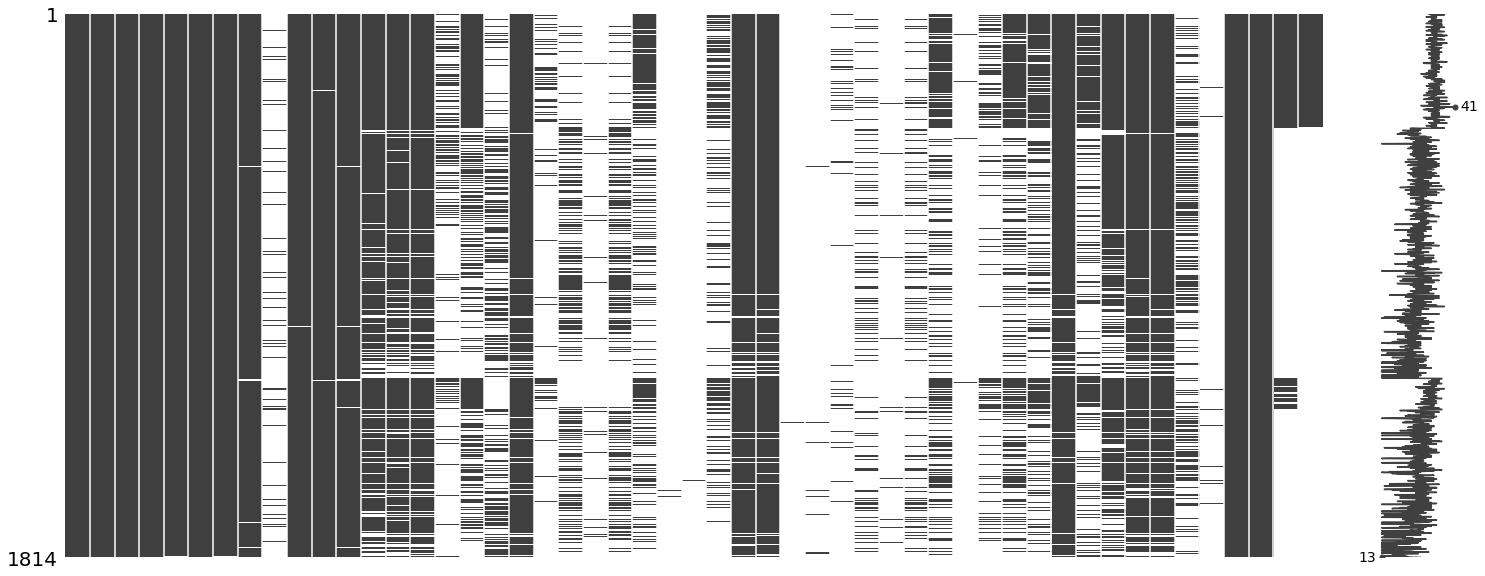

In [5]:
#first, visualize missing values
import missingno as msn
msn.matrix(data)

**Observation** 
1. data contains messy features 
2. 

In [6]:
len(data)

1814

In [7]:
#create a function to check all columns with missing data greater than 90% and drop them

def process_missing_data(data, threshold, inplace_value):
    #create a list to hold columns with missing value above threshold
    drop_cols = []
    
    #create a variable to store all columns in the dataframe
    all_cols = data.columns
    
    #calculate all columns with missing values percentage greater than the threshold
    missing_percentage = (data[all_cols].isna().sum()/len(data))*100
    
    #create a dataframe to store all candidate columns and their percentage
    missing_df = pd.DataFrame({"cols":all_cols, "percentage":missing_percentage})
    
    #check for threshold condition
    missing_filtered = missing_df[missing_df['percentage'] >= threshold] 
    drop_cols.append(missing_filtered["cols"].tolist())
    
    #drop candidate columns
    drop_cols = drop_cols[0]
    data.drop(columns=drop_cols, inplace= inplace_value)
    
    return data.shape


In [8]:
process_missing_data(data=data, threshold=90, inplace_value=True)

(1814, 41)

# **Explore the data**

**First, we see what offices the candidates are campaigning for**

In [9]:
data['can_off'].value_counts(normalize=True, sort=True)

H    0.787762
S    0.125138
P    0.087100
Name: can_off, dtype: float64

**Basically, there are three offices namely**
* H : house of represenatative
* S : senator
* P : presidency

**create three dataframes based on the candidate office**

In [10]:
#first, convert the net_con column to a float data type and modify data inplace
def converter(data, data_col):
    value = data[data_col].str.replace('$','').str.replace(',','').str.replace('(','-').str.replace(')','').astype('float32')
    data[data_col] = value
    return data.head()

#call the function on the net_con feature
converter(data=data, data_col="net_con")

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,tot_dis,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes
0,H2GA12121,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,2237 PICKENS RD,AUGUSTA,GA,...,"$978,518.98","$60,109.57","$175,613.35",1074949.500,"$907,156.21","$1,125,000.00",1/1/2015,10/19/2016,Y,158708.0
1,H6PA02171,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,PO BOX 6578,PHILADELPHIA,PA,...,"$1,313,583.69",NaN,"$105,687.23",1406719.000,"$1,298,831.83",NaN,11/2/2015,10/19/2016,Y,310770.0
2,H6FL04105,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,3817 VICKERS LAKE DRIVE,JACKSONVILLE,FL,...,"$675,642.76",NaN,"$35,645.09",650855.375,"$656,210.29","$60,000.00",4/1/2016,10/19/2016,Y,286018.0
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,WHITEFISH,MT,...,"$5,200,630.00","$83,815.78","$399,122.61",4938943.500,"$5,055,942.15",NaN,1/1/2015,10/19/2016,Y,280476.0
4,H8CA09060,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"409 13TH ST, 17TH FL",OAKLAND,CA,...,"$1,112,163.94","$83,690.60","$181,338.23",1197676.625,"$949,488.98","$4,401.75",1/1/2015,10/19/2016,Y,277390.0


In [11]:
H_df = data.loc[data['can_off'] == "H"] 
S_df = data.loc[data['can_off'] == "S"]
P_df = data.loc[data['can_off'] == "P"]

In [12]:
print(f'The shape of the House of assembly data is {H_df.shape}')
print(f'The shape of the senate data is {S_df.shape}')
print(f'The shape of the presidential data is {P_df.shape}')

The shape of the House of assembly data is (1429, 41)
The shape of the senate data is (227, 41)
The shape of the presidential data is (158, 41)


# let's start by analyzing the house of representative data

**Since we are interested in the finances of the campaign, lets see how much is spent on campaign in each district in a state**


In [13]:
Amt_per_sta_ds = H_df.groupby(['can_off_sta', 'can_off_dis'])['net_con'].sum().to_frame(name = "total_dis_sum").reset_index()

In [14]:
Amt_per_sta_ds.head()

,can_off_sta,can_off_dis,total_dis_sum
0,AK,0.0,1051122.000
1,AL,1.0,1328469.625
2,AL,2.0,1505342.250
3,AL,3.0,1106073.000
4,AL,4.0,1349214.125


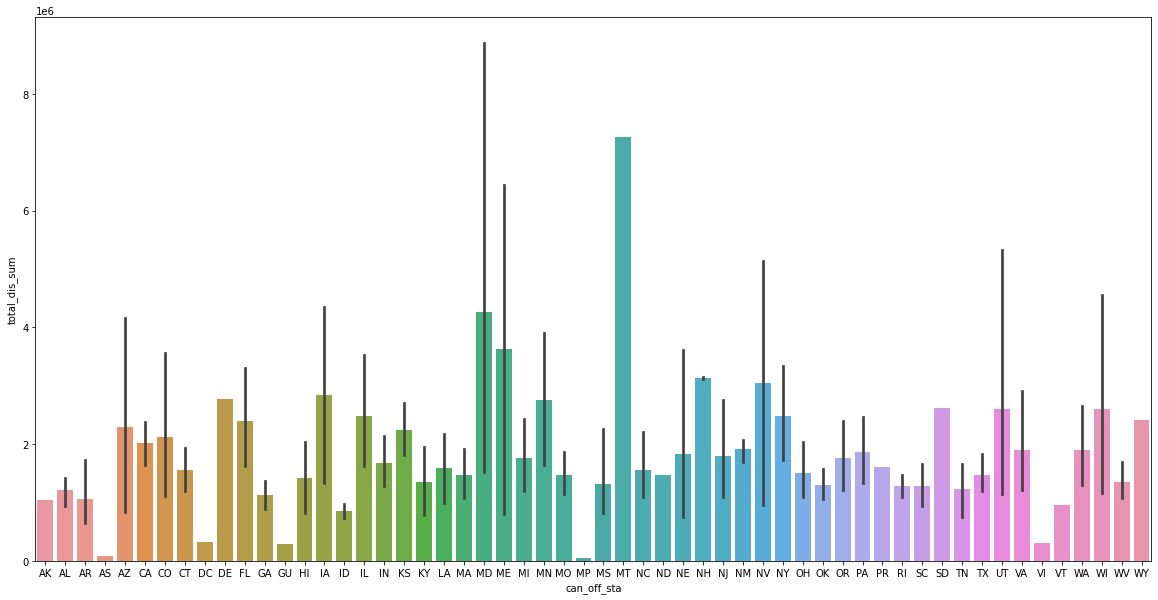

In [15]:
#visualize the state with high spending

#sns.set_theme(style="whitegrid")

plt.figure(figsize=(20,10))

ax = sns.barplot(x="can_off_sta", y="total_dis_sum", data=Amt_per_sta_ds)

We can clearly see that the highest spending state in terms of house of reps election is the MT, let's now go further to see the amount of competitors in that district

In [26]:
mt_comp = H_df.loc[H_df['can_off_sta'] == 'MT']
mt_comp

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,tot_dis,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,WHITEFISH,MT,...,"$5,200,630.00","$83,815.78","$399,122.61",4938943.5,"$5,055,942.15",NaN,1/1/2015,10/19/2016,Y,280476.0
535,H6MT01095,"JUNEAU, DENISE",H,MT,0.0,DEM,CHALLENGER,PO BOX 563,HELENA,MT,...,"$1,869,316.07",NaN,"$491,337.79",2317465.0,"$1,831,515.23",NaN,11/4/2015,10/19/2016,NaN,NaN


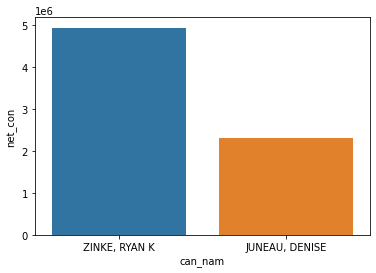

In [17]:
ax = sns.barplot(x='can_nam', y='net_con', data=mt_comp)

we can clearly see that for state MT with just one district, the higest spender won the vote, however, before we conclude, let's check how long each candidate campaigned for

In [18]:
#to achieve this aim, we make use of the two date columns (cov_sta_dat, cov_end_dat)

mt_comp['cov_sta_dat'] = pd.to_datetime(mt_comp['cov_sta_dat'])
mt_comp['cov_end_dat'] = pd.to_datetime(mt_comp['cov_end_dat'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
mt_comp['campaign_duration'] = (mt_comp['cov_end_dat'] - mt_comp['cov_sta_dat']).dt.days

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
mt_comp

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes,campaign_duration
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,WHITEFISH,MT,...,"$83,815.78","$399,122.61",4938943.5,"$5,055,942.15",NaN,2015-01-01,2016-10-19,Y,280476.0,657
535,H6MT01095,"JUNEAU, DENISE",H,MT,0.0,DEM,CHALLENGER,PO BOX 563,HELENA,MT,...,NaN,"$491,337.79",2317465.0,"$1,831,515.23",NaN,2015-11-04,2016-10-19,NaN,NaN,350


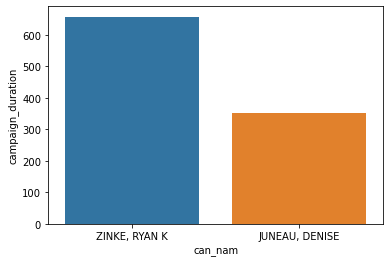

In [21]:
ax = sns.barplot(x='can_nam', y='campaign_duration', data=mt_comp)

**Observation**
it is easy to see a trend in between the the money spent and the number of days used to campaign by a candidate

**Next, we seek to find out the number of candidates vying for a sit in a district(competitors)**

In [22]:
competitors = H_df.groupby(['can_off_sta', 'can_off_dis'])['can_id'].count().to_frame(name = "num_of_comp").reset_index()
#eliminate data points where num_of_comp <= 1
#this means that these positions are unopposed
competitors = competitors[competitors['num_of_comp'] > 1]

In [23]:
competitors.head()

,can_off_sta,can_off_dis,num_of_comp
1,AL,1.0,2
2,AL,2.0,3
3,AL,3.0,3
4,AL,4.0,2
5,AL,5.0,2


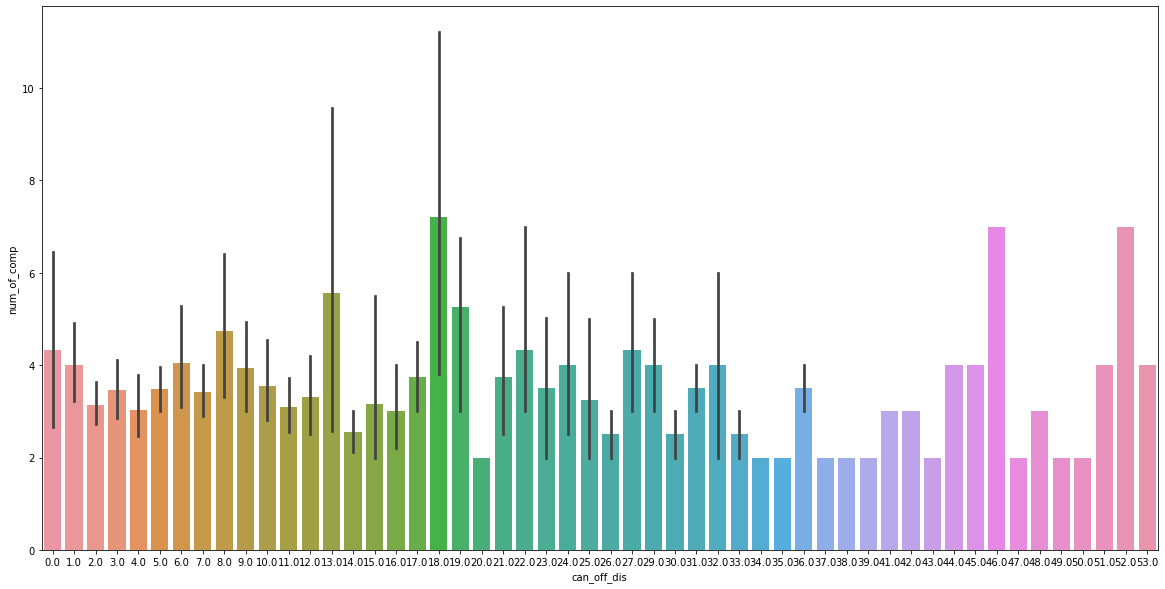

In [24]:
plt.figure(figsize=(20,10))

ax = sns.barplot(x="can_off_dis", y="num_of_comp", data=competitors)

### Before generalizing, let's pick a state at random and test the result of our early analysis

In [29]:
al_comp = H_df.loc[H_df['can_off_sta'] == 'AL']
al_comp.shape

(15, 41)

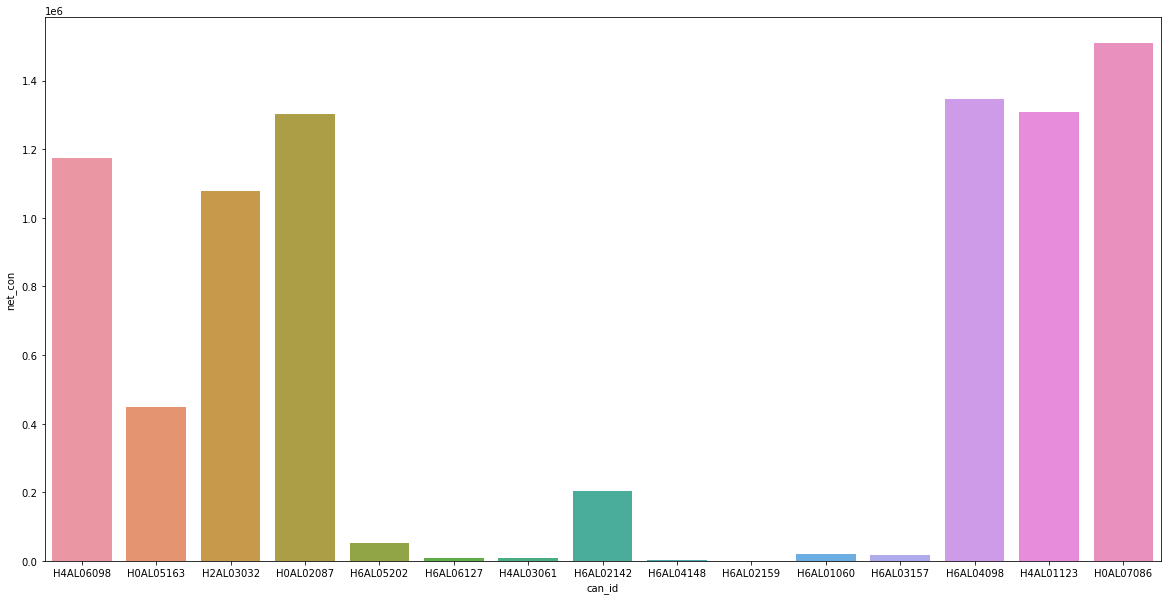

In [32]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x='can_id', y='net_con', data=al_comp)

In [33]:
al_comp

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,tot_dis,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes
27,H4AL06098,"PALMER, GARY",H,AL,6.0,REP,INCUMBENT,1919 OXMOOR RD #235,BIRMINGHAM,AL,...,"$609,868.94","$189,712.50","$781,799.96",1.175074e+06,"$451,946.24",NaN,1/1/2015,10/19/2016,Y,240897.0
121,H0AL05163,"BROOKS, MO",H,AL,5.0,REP,INCUMBENT,7610 FOXFIRE DRIVE,HUNTSVILLE,AL,...,"$92,131.88","$814,436.28","$1,175,733.72",4.499752e+05,"$86,637.98",NaN,1/1/2015,10/19/2016,Y,204791.0
184,H2AL03032,"ROGERS, MICHAEL DENNIS",H,AL,3.0,REP,INCUMBENT,123 EAST 13TH STREET,ANNISTON,AL,...,"$975,920.50","$457,814.01","$565,465.07",1.078677e+06,"$806,683.14",NaN,1/1/2015,10/19/2016,Y,190724.0
332,H0AL02087,"ROBY, MARTHA",H,AL,2.0,REP,INCUMBENT,PO BOX 195,MONTGOMERY,AL,...,"$1,590,594.09","$491,726.24","$224,263.27",1.302074e+06,"$1,304,536.82",NaN,1/1/2015,10/19/2016,Y,134450.0
434,H6AL05202,"BOYD, WILLIE WILL"" DR. JR.""",H,AL,5.0,DEM,CHALLENGER,609 WINDOVER ROAD,FLORENCE,AL,...,"$54,923.85",NaN,$983.08,5.298373e+04,"$54,923.85","$2,893.20",7/1/2015,10/19/2016,NaN,NaN
626,H6AL06127,"PUTMAN, DAVID",H,AL,6.0,DEM,CHALLENGER,PO BOX 660811,VESTAVIA,AL,...,"$67,813.04",NaN,"($13,127.42)",7.645000e+03,"$56,333.96","$40,987.44",7/1/2015,10/19/2016,NaN,NaN
657,H4AL03061,"SMITH, JESSE TREMAIN",H,AL,3.0,DEM,CHALLENGER,1009 1ST PLACE SOUTH,PELL CITY,AL,...,"$6,818.00",NaN,$482.00,9.678000e+03,"$6,818.00",NaN,1/1/2015,10/19/2016,NaN,NaN
816,H6AL02142,"GERRITSON, REBECCA (BECKY)",H,AL,2.0,REP,CHALLENGER,50 COUNTRY CLUB DRIVE,WETUMPKA,AL,...,"$206,908.19",NaN,NaN,2.032584e+05,"$203,258.38",NaN,7/1/2015,9/30/2016,NaN,NaN
1084,H6AL04148,"NORRIS, PHILLIP",H,AL,4.0,REP,CHALLENGER,215 MAGNOLIA RIDGE PLACE,DOTHAN,AL,...,"$3,605.76",NaN,NaN,3.549690e+03,"$3,550.00",NaN,4/1/2015,6/24/2016,NaN,NaN
1122,H6AL02159,"ROGERS, ROBERT L",H,AL,2.0,REP,CHALLENGER,3393 CARTER HILL ROAD,MONTGOMERY,AL,...,"$32,492.00",NaN,NaN,1.000000e+01,"$50,187.00",NaN,10/29/2015,4/15/2016,NaN,NaN


**by this inspection, it is safe to say our assumption stands with respect to money**

In [ ]:
#export processed data to csv for analysis in microsoft BI
data.to_csv("stage_f_data.csv", index=False)